<a href="https://colab.research.google.com/github/zhangxz1123/NN_convergence/blob/master/2a_gam_additive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title License
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
#@title Imports

from __future__ import division
from __future__ import print_function
import os.path as osp
import json
import re
from IPython.display import display
from copy import copy
from collections import Counter
import numpy as np
import pandas as pd
import functools

import matplotlib.pyplot as plt
from google.colab import widgets
from matplotlib import pylab

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [0]:
#@title Enable v2 behaviour
tf.enable_v2_behavior()


In [4]:
#@title Upload the file "medis984c.data"
from google.colab import files
files.upload()

Saving medis9847c.data to medis9847c.data


{u'medis9847c.data': '82\t0\t1\t0\t0\t0\t0\t1\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t0\t1\t0\t0\t0\t24\t0\t0\t0\t0\t0\t33\t1.8\t0\t0\t0\t0\t0\t0\t0\t15.1\t0\t0\t0\t0\t0\t0\t0\t0\n24\t1\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t17\t0\t0\t1\t0\t0\t0\t26\t0\t0\t0\t0\t30\t0\t0\t0\t0\t3\t0\t7.48\t0\t0\t22.6\t1\t1\t0\t0\t0\t0\t0\t0\n82\t1\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t28\t0\t38.33\t0\t0\t17\t73\t2\t0\t0\t3\t158\t7.54\t48\t0\t4.6\t0\t0\t0\t0\t0\t0\t0\t0\n78\t0\t1\t0\t1\t0\t0\t1\t1\t1\t0\t0\t0\t0\t3\t0\t0\t0\t0\t1\t0\t0\t0\t36\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t0\t46\t0\t12.6\t1\t1\t0\t0\t0\t0\t0\t0\n94\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t1\t0\t0\t0\t0\t1\t0\t0\t0\t0\t0\t32.5\t0\t0\t0\t165\t11.4\t0\t16.4\t6.7\t154\t6.99\t0\t0\t0\t1\t1\t0\t0\t0\t0\t0\t0\n69\t1\t1\t0\t1\t0\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t0\t0\t1\t0\t0\t0\t22\t0\t0\t0\t0\t0\t0\t0\t0\t0\t2.8\t0\t0\t72\t46\t16.1\t1\t1\t0\t0\t0\t0\t0\t0\n90\t1\t1\t0\t0\t0\t0\t0\t0\t0\t0\t1\t0\t0\t1\t1\t0\t0\t1\t0\t0\t

In [0]:
def standardize_func(x):
  x_max, x_min = np.max(x), np.min(x)
  if x_min >= x_max:
    # Implies that min and max are same, meaning all values are identical
    return np.zeros_like(x), (x_min, x_max)
  else:
    return standardize(x, x_min, x_max), (x_min, x_max)
  
def standardize(x, x_min, x_max):
  return (2*x - (x_max + x_min))/(x_max - x_min)
  
def normalize(x):
  data_mean = np.mean(x)
  data_var = np.mean(np.square(x - data_mean))
  data_points = (x - data_mean)/(data_var + 1e-8)
  return data_points, (data_mean, data_var)

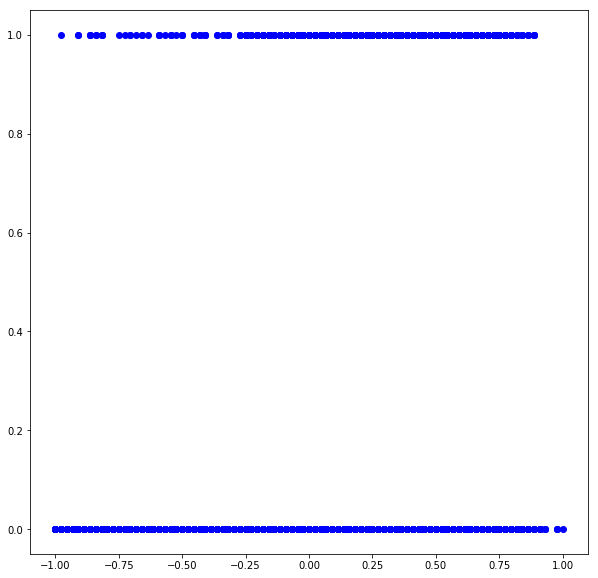

In [6]:
#@title Dataset Processing

# Read dataset
file_name = "medis9847c.data"
df = pd.read_csv(file_name, header = None, sep='\t')
val = df.values

# extract the age feature and normalize it to within the range where most activation threshold lies
x = val[:, 0]
# extract the labels
y = val[:,-1]

# Process and plot dataset  

data_points, _ = standardize_func(x)

#"""
data_points = data_points[:, np.newaxis]
data_targets = y

NUM_DATAPOINTS = len(data_points)

plt.figure(figsize=(10, 10))
plt.plot(data_points, data_targets, 'bo', label='original data')
plt.show()

In [0]:
df_train = df.iloc[:, :-1]
df_out = df.iloc[:, -1]
df_max = df_train.max(axis=0)
df_min = df_train.min(axis=0)
df_train = standardize(df_train, df_min, df_max)

In [8]:
df_train.shape[-1]

46

In [0]:
num_unique_vals = [len(df_train[i].unique()) for i in range(df_train.shape[-1])]

In [0]:
msk = np.random.rand(len(df_train)) <= 0.9
x_train = df_train[msk].values
y_train = df_out[msk].values
x_test = df_train[~msk].values
y_test = df_out[~msk].values

In [0]:
data_points = x_train
# Convert data targets to float
data_targets = 1.0 * y_train
data_points_tensor = tf.convert_to_tensor(data_points)
NUM_DATAPOINTS = len(data_points)

In [0]:
#@title Model Helpers

class RBFLayer(tf.keras.layers.Layer):
  
  def __init__(self, num_units, trainable=True, center_init=(-1, 1)):
    super(RBFLayer, self).__init__(trainable=trainable)
    self.num_units = num_units  
    sgn = 2 * np.random.randint(2, size = self.num_units) - 1
    self.sgn = tf.cast(sgn, dtype=tf.float64)
    # Initializing this to lie within the data range
    self._min_val, self._max_val = center_init

  def build(self, input_shape):
    self.beta = self.add_weight(
        name='beta',
        shape=[input_shape[-1], self.num_units],
        initializer=tf.initializers.constant(5.0),
        trainable=True)
    self.c = self.add_weight(
        name='c',
        shape=[1, self.num_units],
        initializer=tf.initializers.truncated_normal(stddev=0.5), 
            # self._min_val, self._max_val),
        trainable=True)

  def call(self, x):
    center = tf.tile(self.c, [tf.shape(x)[0], 1])
    distances = tf.abs(x - center)
    out = tf.exp(self.beta) * (x - center)
    out = tf.clip_by_value(self.sgn * out, -1, 1)
    # out = tf.tanh(out)
    return out


class SimpleNN(tf.keras.Model):
  """Simple NN model."""

  def __init__(self, num_units, **kwargs):
    super(SimpleNN, self).__init__()
    self.rbf_layer = RBFLayer(num_units, **kwargs)
    # self.batch_norm = tf.keras.layers.BatchNormalization()
    self.linear = tf.keras.layers.Dense(
        1, use_bias=True,
        kernel_initializer=tf.initializers.random_uniform(-1, 1))
   
  def call(self, x, training=True):
    x = self.rbf_layer(x)
    # x = self.batch_norm(x, training=training)
    x = tf.squeeze(self.linear(x), axis=-1)
    return x 


class ComplexNN(tf.keras.Model):
  def __init__(self, num_inputs, num_units, **kwargs):
    super(ComplexNN, self).__init__()
    self.num_inputs = num_inputs
    if isinstance(num_units, list):
      assert len(num_units) == num_inputs
      self.simple_nns = [SimpleNN(num_units[i], **kwargs) 
                        for i in range(num_inputs)]
    elif isinstance(num_units, int):
      self.simple_nns = [SimpleNN(num_units, **kwargs)
                        for _ in range(num_inputs)]
    
  def call(self, x, training=True):
    return tf.add_n(self.calc_outputs(x, training=training)) 

  def calc_outputs(self, x, training=True):
    list_x = tf.split(x, self.num_inputs, axis=-1)
    return [self.simple_nns[i](x_i, training=training) for i, x_i in enumerate(list_x)] 

In [0]:
#@title Create tf Dataset
# Assume that each row of `features` corresponds to the same row as `labels`.
assert data_points.shape[0] == data_targets.shape[0]
dataset = tf.data.Dataset.from_tensor_slices((data_points, data_targets))

BATCH_SIZE = 1024 #@param {type: "integer"}
BATCH_SIZE = min(BATCH_SIZE, NUM_DATAPOINTS)
# ds_tensors = dataset.map(lambda x, y : (x/100, y))
ds_tensors = dataset 
ds_tensors = ds_tensors.apply(tf.data.experimental.shuffle_and_repeat(
    buffer_size=NUM_DATAPOINTS)).batch(BATCH_SIZE)

In [0]:
#@title Training Helpers

def cross_entropy_loss(model, inputs, targets):
  predicted_y = model(inputs)
  logits = tf.stack([predicted_y, tf.zeros_like(predicted_y)], axis=1)
  labels = tf.stack([targets, 1 - targets], axis=1)
  loss_vals = tf.nn.softmax_cross_entropy_with_logits_v2(
      labels=labels, logits=logits)
  return tf.reduce_mean(loss_vals)

def penalized_cross_entropy_loss(model, inputs, targets, reg):
  ce_loss = cross_entropy_loss(model, inputs, targets)
  reg_loss = reg * logit_regularization(model, inputs)
  return ce_loss + reg_loss

def logit_regularization(model, inputs):
  per_feature_logits = model.calc_outputs(inputs)
  per_feature_norm = [  # L1 Regularization
    tf.reduce_mean(tf.abs(logits)) for logits in per_feature_logits
  ]
  return tf.add_n(per_feature_norm) / len(per_feature_norm)

def mse_loss(model, inputs, targets):
  predicted = model(inputs)
  return tf.losses.mean_squared_error(predicted, targets)

def accuracy(model, inputs, targets):
  pred = tf.cast(model(inputs, training=False) > 0, dtype=tf.int32),
  correct = tf.equal(pred, tf.cast(targets > 0.5, dtype=tf.int32))
  accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
  return accuracy  

def grad(model, inputs, targets, loss_fn=cross_entropy_loss, train_vars=None):
  with tf.GradientTape() as tape:
    loss_value = loss_fn(model, inputs, targets)
  if train_vars is None:
    train_vars = model.trainable_variables
  return loss_value, tape.gradient(loss_value, train_vars)

In [307]:
#@title Neural Network Model
# center_init = (np.min(data_points), np.max(data_points))
center_init = (-1, 1)
max_num_units = 100 #@param {"type":"integer"}
num_units = [min(max_num_units, i*2) for i in num_unique_vals]
num_inputs = data_points.shape[-1]
nn_model = ComplexNN(num_inputs=num_inputs, 
                     num_units=num_units,
                     center_init=center_init)
print(nn_model(data_points_tensor[:BATCH_SIZE], training=False))
nn_model.summary()

tf.Tensor(
[-13.37224887  40.33605575 -20.70041423 ...  -6.3344588  -11.66813236
  -1.55947709], shape=(1024,), dtype=float64)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_nn_414 (SimpleNN)     multiple                  301       
_________________________________________________________________
simple_nn_415 (SimpleNN)     multiple                  13        
_________________________________________________________________
simple_nn_416 (SimpleNN)     multiple                  13        
_________________________________________________________________
simple_nn_417 (SimpleNN)     multiple                  13        
_________________________________________________________________
simple_nn_418 (SimpleNN)     multiple                  13        
_________________________________________________________________
simple_nn_419 (SimpleNN)     multiple                  13        
_______________

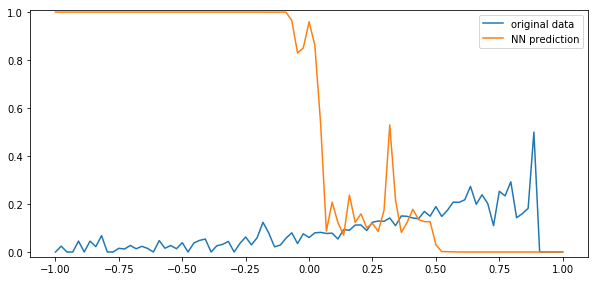

In [308]:
#@title Plot helpers

def plot_hist(index=0, figsize=(10, 10)):  
  val = data_targets
  age = data_points[:, index:index+1]
  unique_age = np.unique(age)
  get_indices = lambda i:  np.multiply(age[:,0] >= i-0, age[:,0] <= i+0)
  h = np.asarray([np.mean(val[get_indices(i)]) for i in unique_age]) # the histogram
  ## Plot the results
  plt.figure(figsize = figsize)

  plt.subplot(2,1,1)
  ## The marginalization plot p(y|x), which is the optimal predictor
  plt.plot(unique_age, h, label = 'original data')

  ## The plot of the neural net's prediction
  pred = nn_model.simple_nns[index](unique_age[:, np.newaxis], training=False)
  pred = tf.sigmoid(pred).numpy()
  plt.plot(unique_age, pred, label = 'NN prediction')
  plt.legend()
  plt.ylim(-0.02, 1.01)
  plt.show()

"""
def plot_fig():
  plt.figure(figsize = (10, 10))
  plt.subplot(2,1,1)
  plt.title('label vs. prediction')
  plt.plot(data_points, data_targets,'o',label = 'original data')
  pred_logits = nn_model.simple_nns(data_points)
  predicted = tf.sigmoid(pred_logits).numpy()
  plt.plot(data_points, predicted, 'x', label = 'NN prediction')
  plt.legend()
  plt.show()
plot_fig()
"""

def plot_all_hist():
  num_cols = 3
  num_rows = int(np.ceil(num_inputs * 1.0 / num_cols))
  grid = widgets.Grid(num_rows, num_cols)
  figsize = (12 - num_cols, 12 - num_cols)
  for i, (row, col) in enumerate(grid):
    if i >= num_inputs:
      break
    plot_hist(i, figsize)

plot_hist(index=0)

Rank 63
Singular values-> Min: 1.63661957279e-31 Max: 829.765521309


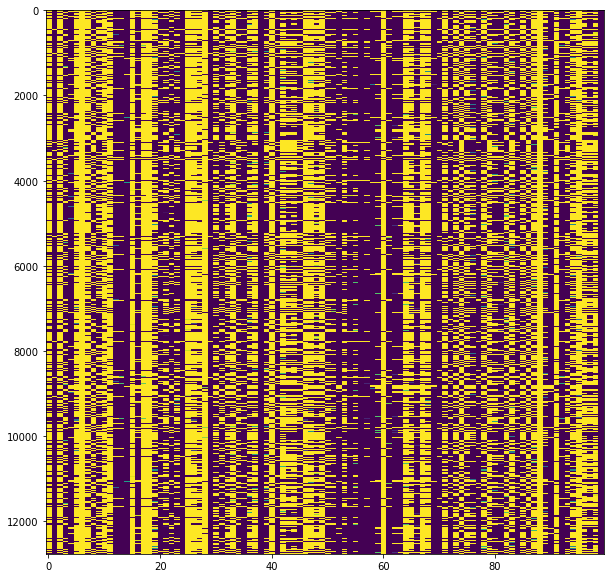

In [309]:
#@title Feature matrix Inspection 
# Code from Simon Kornblith 

unique_age = np.unique(data_points[:, 0])
X = nn_model.simple_nns[0].rbf_layer(data_points_tensor[:, :1])

plt.gcf().set_size_inches((10, 10))
plt.imshow(X, aspect='auto', interpolation='nearest')

# Calculate rank and eigenvalues
rank = np.linalg.matrix_rank(X)
print('Rank {}'.format(rank))

# Singular values of the feature matrix
eigs = np.linalg.svd(X, full_matrices=False, compute_uv=False)
print('Singular values-> Min: {} Max: {}'.format(np.min(eigs), np.max(eigs)))

# assert rank >= len(unique_age), "Rank should be at least number of unique " \
# "datapoints to fit data perfectly"

In [0]:
#@title Learning Rate Decay
learning_rate = 1e-1 #@param {"type": "number"}
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(
    learning_rate, 
    global_step, 
    decay_steps=100,
    decay_rate=0.5)
optimizer = tf.train.AdamOptimizer(learning_rate)

Iter 011: Loss: 14.014704 Accuracy: 0.826
Iter 023: Loss: 7.518759 Accuracy: 0.849
Iter 035: Loss: 3.677850 Accuracy: 0.851
Iter 047: Loss: 1.759689 Accuracy: 0.861
Iter 059: Loss: 1.032780 Accuracy: 0.852
Iter 071: Loss: 0.708745 Accuracy: 0.863
Iter 083: Loss: 0.857604 Accuracy: 0.867
Iter 095: Loss: 0.648925 Accuracy: 0.868
Iter 107: Loss: 1.075516 Accuracy: 0.832
Iter 119: Loss: 0.686024 Accuracy: 0.872
Plot in Iteration 119


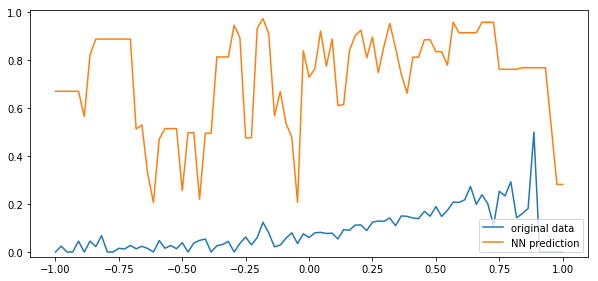

Iter 131: Loss: 0.561887 Accuracy: 0.869
Iter 143: Loss: 0.436906 Accuracy: 0.883
Iter 155: Loss: 0.398923 Accuracy: 0.886
Iter 167: Loss: 0.409387 Accuracy: 0.879
Iter 179: Loss: 0.386063 Accuracy: 0.885
Iter 191: Loss: 0.354631 Accuracy: 0.891
Iter 203: Loss: 0.352351 Accuracy: 0.891
Iter 215: Loss: 0.365079 Accuracy: 0.888
Iter 227: Loss: 0.377833 Accuracy: 0.886
Iter 239: Loss: 0.350754 Accuracy: 0.891
Plot in Iteration 239


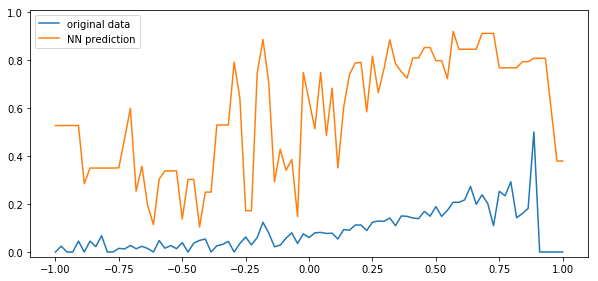

Iter 251: Loss: 0.334694 Accuracy: 0.890
Iter 263: Loss: 0.327588 Accuracy: 0.893
Iter 275: Loss: 0.333970 Accuracy: 0.890
Iter 287: Loss: 0.333616 Accuracy: 0.893
Iter 299: Loss: 0.328907 Accuracy: 0.896
Iter 311: Loss: 0.320160 Accuracy: 0.893
Iter 323: Loss: 0.319487 Accuracy: 0.892
Iter 335: Loss: 0.315212 Accuracy: 0.896
Iter 347: Loss: 0.314819 Accuracy: 0.895
Iter 359: Loss: 0.308683 Accuracy: 0.896
Plot in Iteration 359


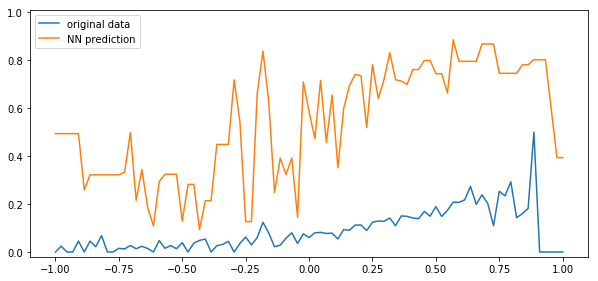

Iter 371: Loss: 0.309209 Accuracy: 0.894
Iter 383: Loss: 0.307225 Accuracy: 0.898
Iter 395: Loss: 0.315685 Accuracy: 0.893
Iter 407: Loss: 0.304964 Accuracy: 0.894
Iter 419: Loss: 0.309006 Accuracy: 0.897
Iter 431: Loss: 0.308306 Accuracy: 0.895
Iter 443: Loss: 0.306857 Accuracy: 0.895
Iter 455: Loss: 0.311360 Accuracy: 0.892
Iter 467: Loss: 0.291444 Accuracy: 0.901
Iter 479: Loss: 0.306272 Accuracy: 0.894
Plot in Iteration 479


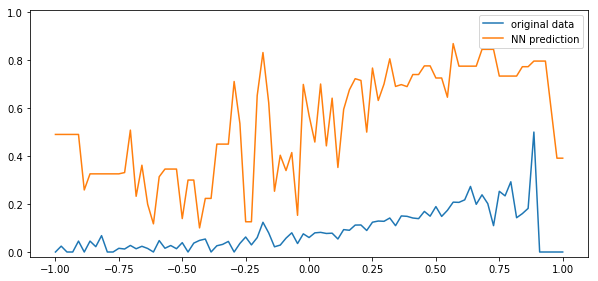

Iter 491: Loss: 0.301747 Accuracy: 0.896
Iter 503: Loss: 0.308595 Accuracy: 0.893
Iter 515: Loss: 0.296819 Accuracy: 0.901
Iter 527: Loss: 0.301516 Accuracy: 0.897
Iter 539: Loss: 0.297307 Accuracy: 0.897
Iter 551: Loss: 0.299228 Accuracy: 0.897
Iter 563: Loss: 0.302620 Accuracy: 0.893
Iter 575: Loss: 0.294382 Accuracy: 0.898
Iter 587: Loss: 0.300621 Accuracy: 0.897
Iter 599: Loss: 0.296845 Accuracy: 0.897
Plot in Iteration 599


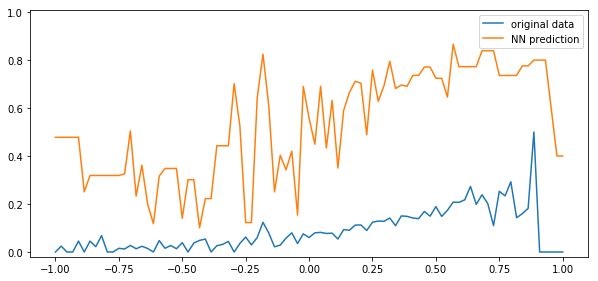

Iter 611: Loss: 0.296628 Accuracy: 0.899
Iter 623: Loss: 0.299639 Accuracy: 0.896
Iter 635: Loss: 0.296561 Accuracy: 0.898
Iter 647: Loss: 0.298993 Accuracy: 0.897
Iter 659: Loss: 0.298077 Accuracy: 0.896
Iter 671: Loss: 0.292278 Accuracy: 0.899
Iter 683: Loss: 0.298302 Accuracy: 0.898
Iter 695: Loss: 0.298510 Accuracy: 0.895
Iter 707: Loss: 0.297425 Accuracy: 0.897
Iter 719: Loss: 0.296658 Accuracy: 0.900
Plot in Iteration 719


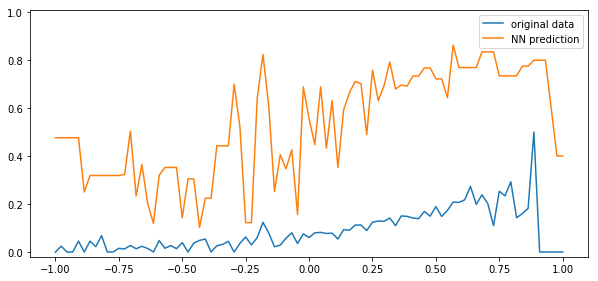

Iter 731: Loss: 0.296193 Accuracy: 0.897
Iter 743: Loss: 0.294619 Accuracy: 0.898
Iter 755: Loss: 0.298073 Accuracy: 0.898
Iter 767: Loss: 0.294674 Accuracy: 0.896
Iter 779: Loss: 0.295995 Accuracy: 0.900
Iter 791: Loss: 0.291366 Accuracy: 0.897
Iter 803: Loss: 0.293745 Accuracy: 0.899
Iter 815: Loss: 0.299529 Accuracy: 0.896
Iter 827: Loss: 0.291826 Accuracy: 0.899
Iter 839: Loss: 0.297581 Accuracy: 0.897
Plot in Iteration 839


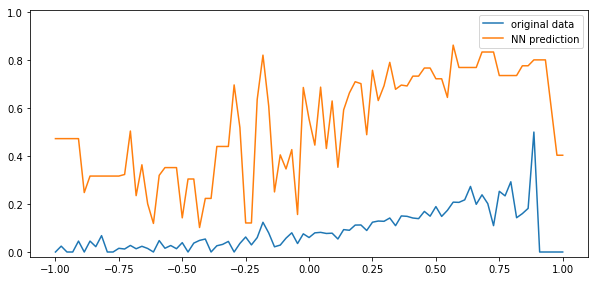

Iter 851: Loss: 0.295721 Accuracy: 0.897
Iter 863: Loss: 0.295185 Accuracy: 0.897
Iter 875: Loss: 0.301257 Accuracy: 0.895
Iter 887: Loss: 0.285539 Accuracy: 0.902
Iter 899: Loss: 0.301950 Accuracy: 0.896
Iter 911: Loss: 0.289691 Accuracy: 0.899
Iter 923: Loss: 0.301303 Accuracy: 0.896
Iter 935: Loss: 0.293044 Accuracy: 0.898
Iter 947: Loss: 0.293974 Accuracy: 0.898
Iter 959: Loss: 0.296074 Accuracy: 0.897
Plot in Iteration 959


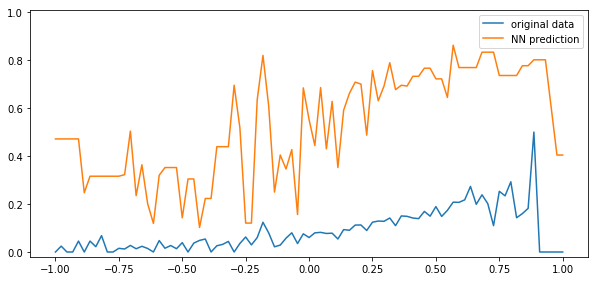

Iter 971: Loss: 0.293095 Accuracy: 0.898
Iter 983: Loss: 0.297272 Accuracy: 0.897
Iter 995: Loss: 0.293494 Accuracy: 0.899
Iter 1007: Loss: 0.295584 Accuracy: 0.897
Iter 1019: Loss: 0.296045 Accuracy: 0.897
Iter 1031: Loss: 0.293895 Accuracy: 0.899
Iter 1043: Loss: 0.297000 Accuracy: 0.896
Iter 1055: Loss: 0.291610 Accuracy: 0.900
Iter 1067: Loss: 0.291153 Accuracy: 0.900
Iter 1079: Loss: 0.299593 Accuracy: 0.895
Plot in Iteration 1079


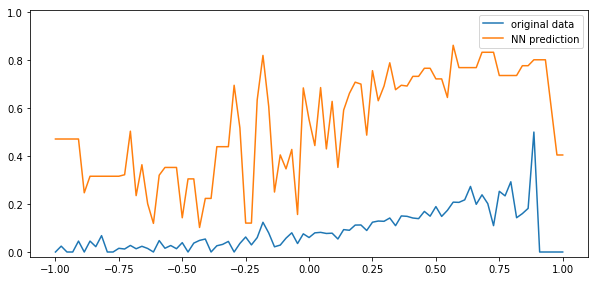

Iter 1091: Loss: 0.290441 Accuracy: 0.897
Iter 1103: Loss: 0.302710 Accuracy: 0.896
Iter 1115: Loss: 0.291436 Accuracy: 0.900
Iter 1127: Loss: 0.283242 Accuracy: 0.900
Iter 1139: Loss: 0.302383 Accuracy: 0.896
Iter 1151: Loss: 0.294614 Accuracy: 0.898
Iter 1163: Loss: 0.296771 Accuracy: 0.896
Iter 1175: Loss: 0.291911 Accuracy: 0.899
Iter 1187: Loss: 0.299552 Accuracy: 0.897
Iter 1199: Loss: 0.292480 Accuracy: 0.896
Plot in Iteration 1199


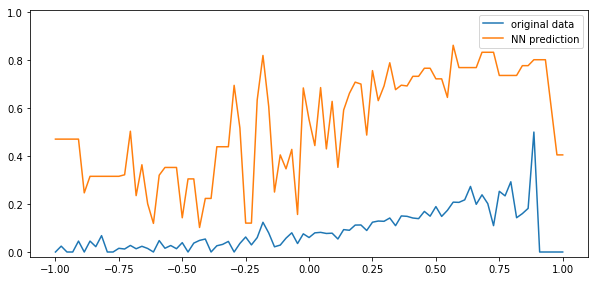

In [315]:
#@title Gradient Descent Training
train_loss_results = []
train_accuracy_results = []

iteration = 0
num_iters_per_epoch = (NUM_DATAPOINTS // BATCH_SIZE)
num_epochs = 100 #@param
reg = 5e-2 #@param {"type": "number"}
num_iters = num_epochs * num_iters_per_epoch
epoch = 0

tfe = tf.contrib.eager
epoch_loss_avg = tfe.metrics.Mean()
epoch_accuracy = tfe.metrics.Accuracy()
loss_fn = functools.partial(penalized_cross_entropy_loss, reg=reg)
grad_fn = lambda x, y, z: grad(
    nn_model, x, y, loss_fn=loss_fn, train_vars=z)
train_all_vars = True #@param {"type": "boolean"}

if train_all_vars:
  train_vars = nn_model.trainable_variables
else:
  train_vars = []
  for snn in nn_model.simple_nns:
    train_vars += snn.layers[-1].trainable_variables

# Training loop - using batches of size `BATCH_SIZE`
for x, y in ds_tensors:   
  # Optimize the model
  loss_value, grads = grad_fn(x, y, train_vars)
  optimizer.apply_gradients(
      zip(grads, train_vars), global_step)

  # Track progress
  epoch_loss_avg(loss_value)  # add current batch loss
  # compare predicted label to actual label
  epoch_accuracy(tf.cast(nn_model(x, training=False) > 0, dtype=tf.int32),
                tf.cast(y > 0.5, dtype=tf.int32))
  
  if (iteration + 1) % num_iters_per_epoch == 0:
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print("Iter {:03d}: Loss: {:.6f} Accuracy: {:.3f}".format(
        iteration, epoch_loss_avg.result(),
        epoch_accuracy.result()))
          
    if (iteration + 1) % (num_iters_per_epoch * 10) == 0:
      print('Plot in Iteration {}'.format(iteration))
      plot_hist()

    # reset epoch counters
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

  iteration += 1
  if iteration > num_iters:
    break

In [316]:
#@title Test Accuracy
acc = accuracy(nn_model, x_test, y_test)
print('Test accuracy is: {}'.format(acc.numpy()))

Test accuracy is: 0.883379876614


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

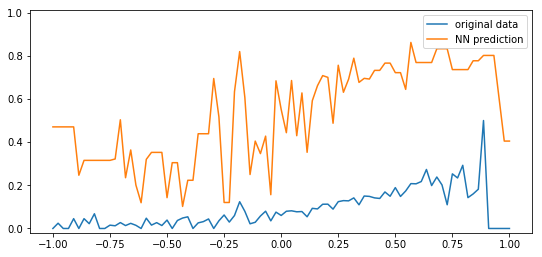

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

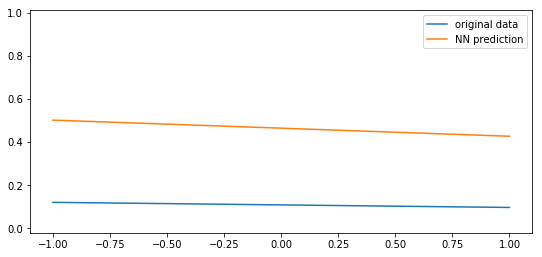

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

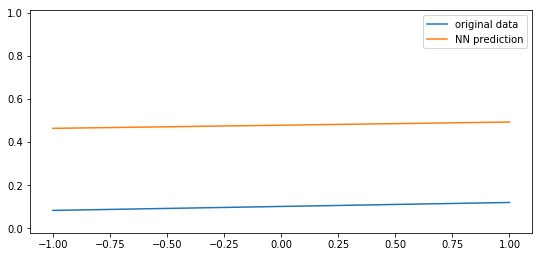

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

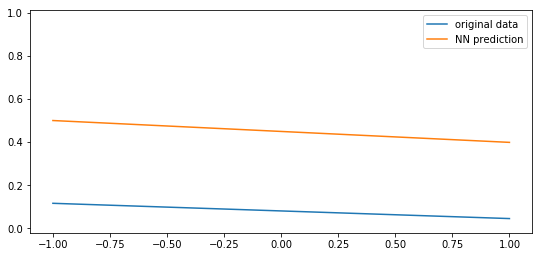

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

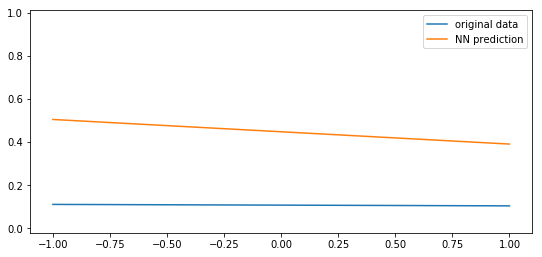

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

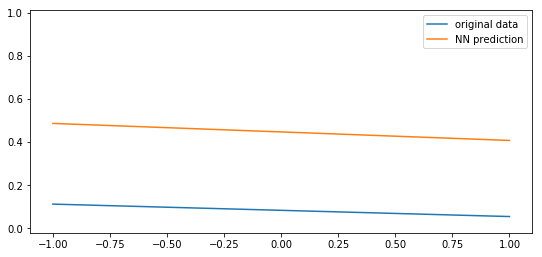

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

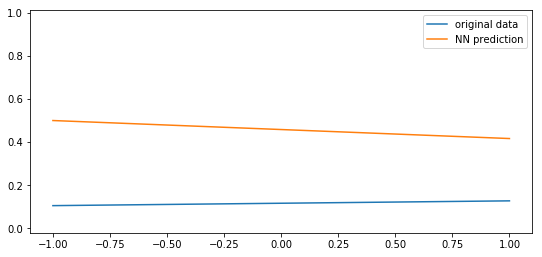

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

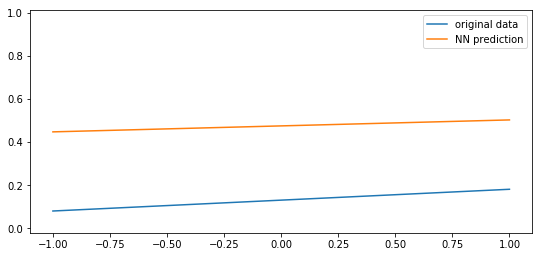

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

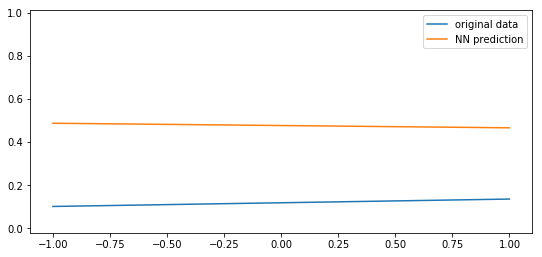

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

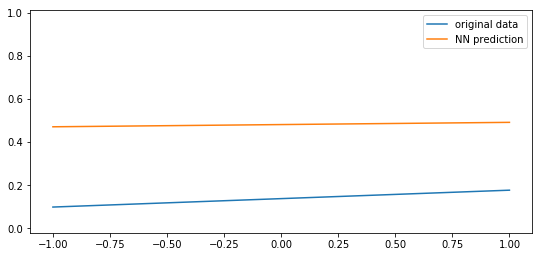

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

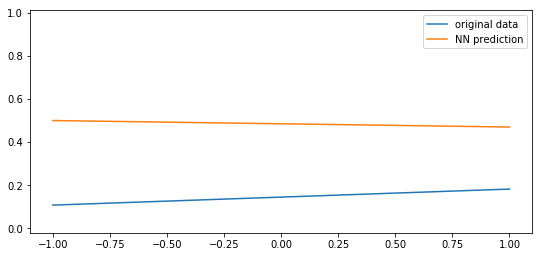

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

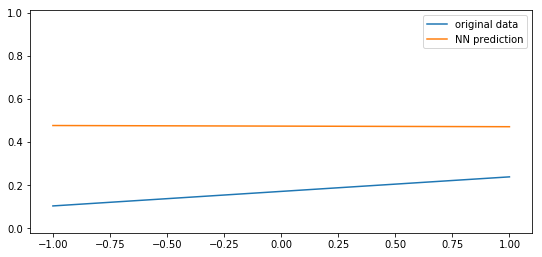

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

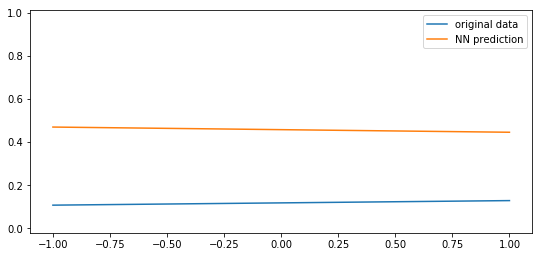

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

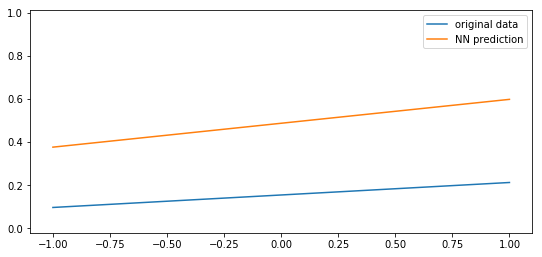

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

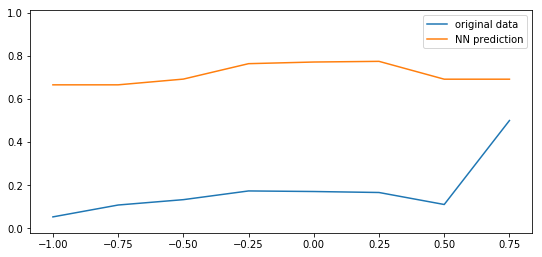

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

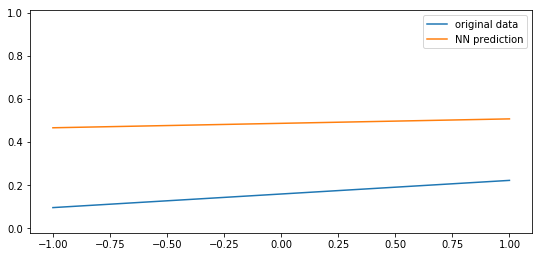

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

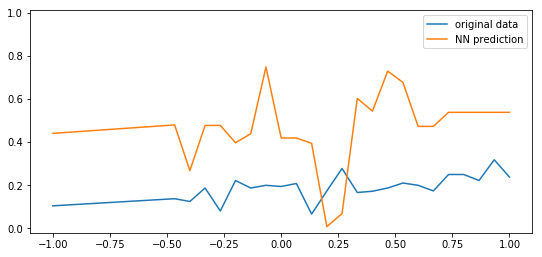

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

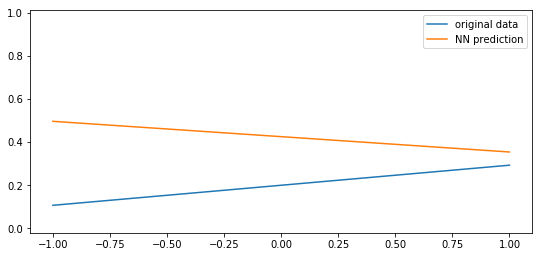

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

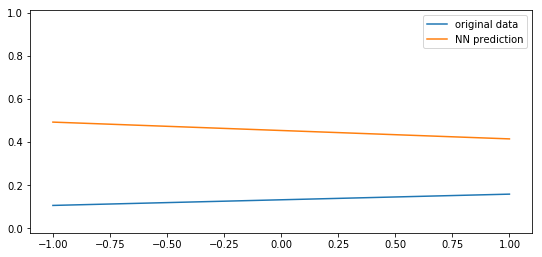

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

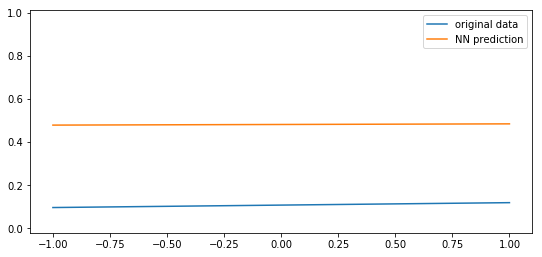

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

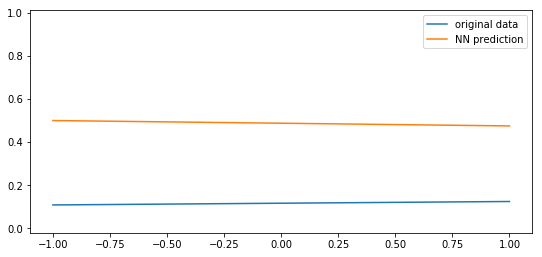

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

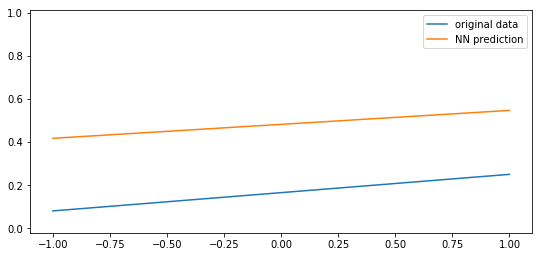

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

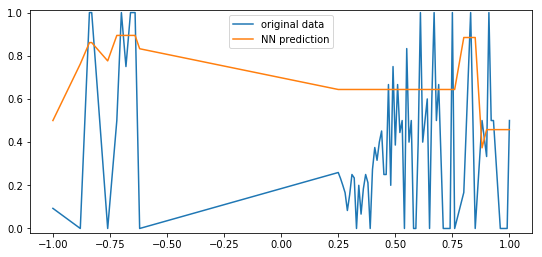

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

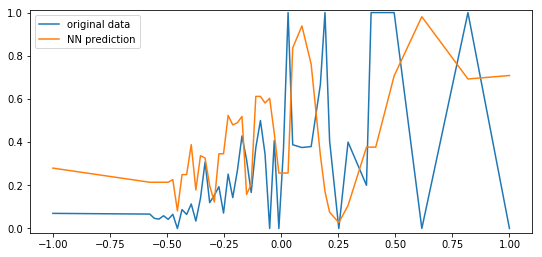

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

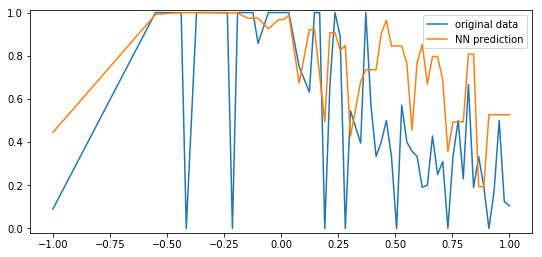

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

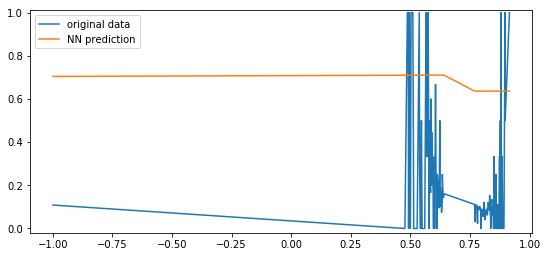

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

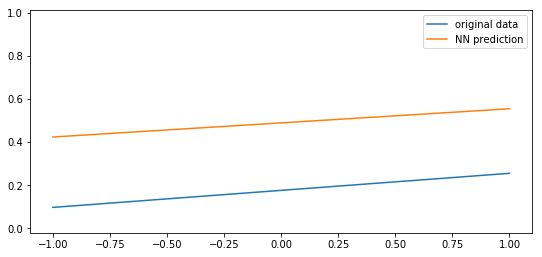

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

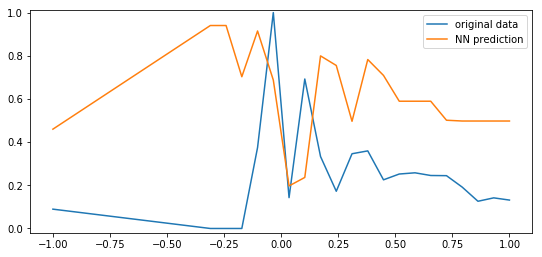

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

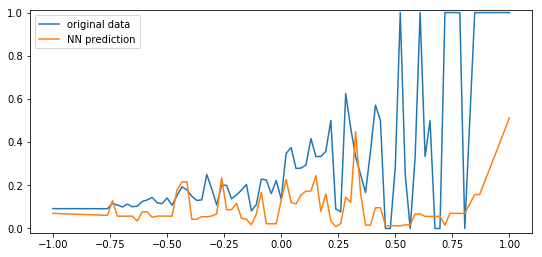

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

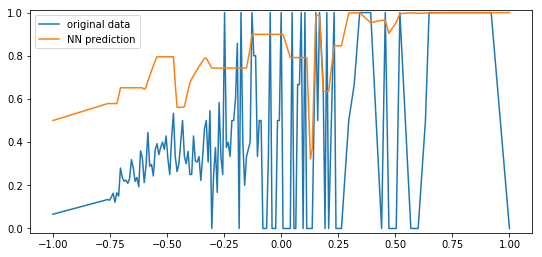

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

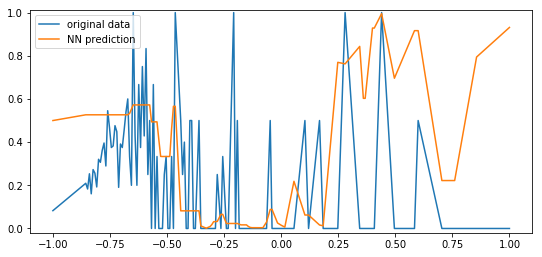

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

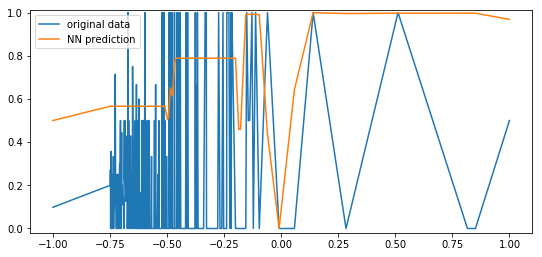

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

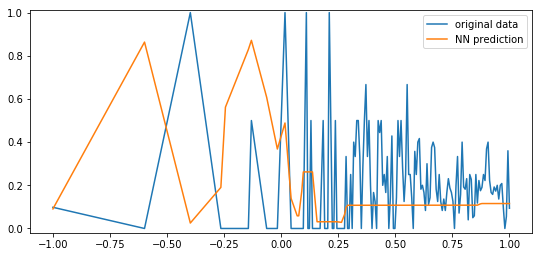

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

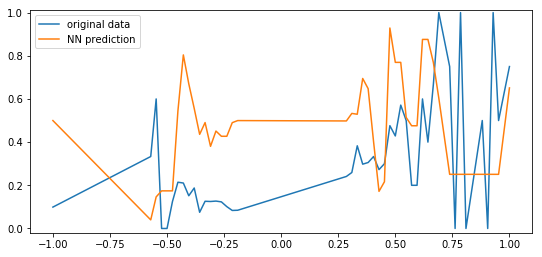

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

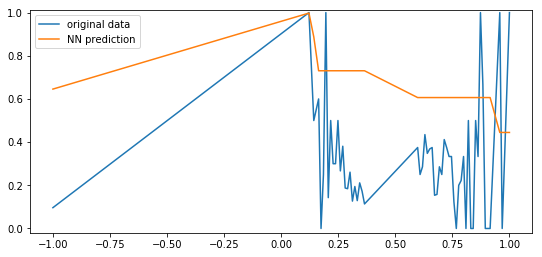

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

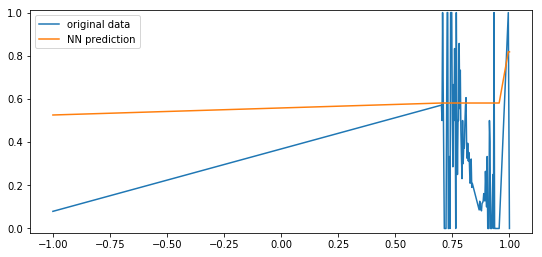

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

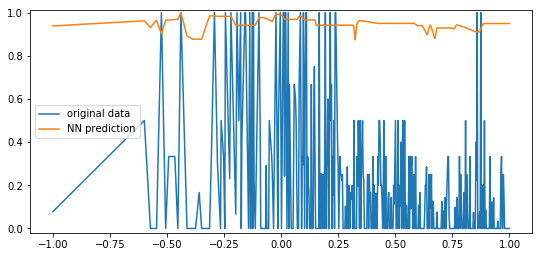

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

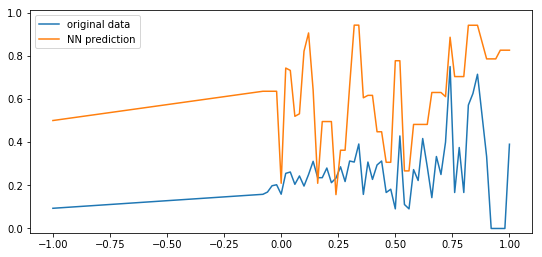

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

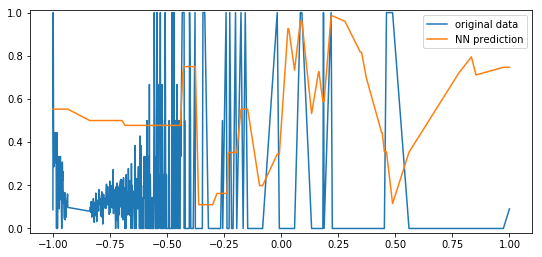

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

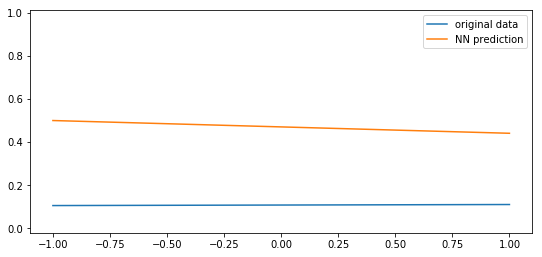

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

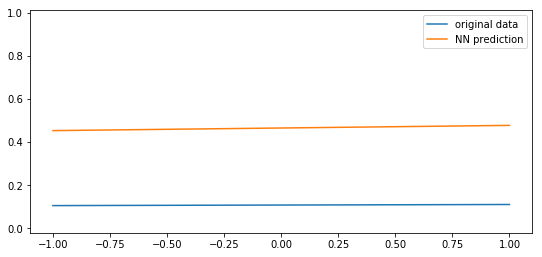

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

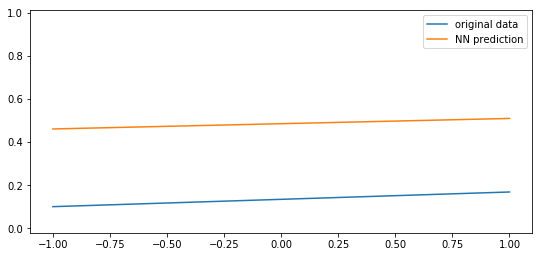

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

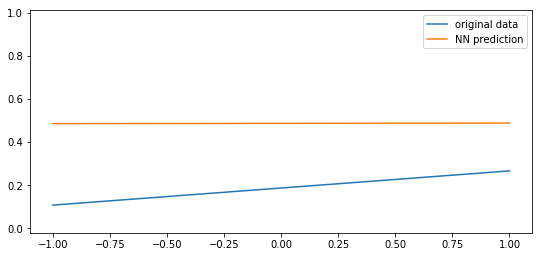

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

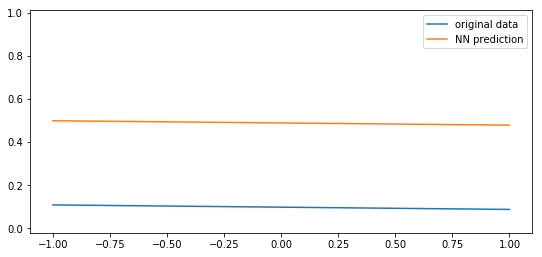

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

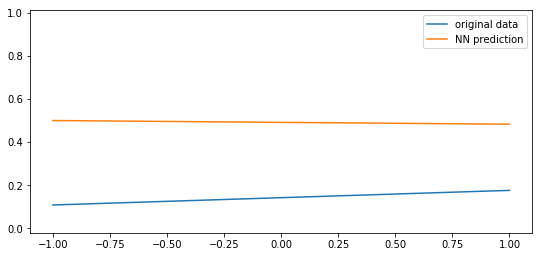

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

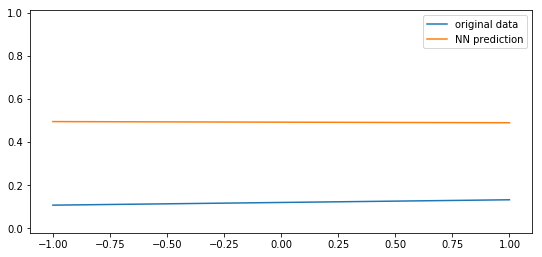

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [317]:
#@title Histogram plot after few gradient descent steps
plot_all_hist()

## Second Order Optimization
---


In [0]:
#@title Helpers for using Scipy Optimize 
import scipy.optimize

compute_loss = lambda x: penalized_cross_entropy_loss(
  x, data_points_tensor, data_targets, reg=reg)

Nfeval = 1  # Iteration Number

def extract_weights(x):
  return [x[:-1, np.newaxis], x[-1, np.newaxis]]  

def merge_weights(W, b):
  return np.concatenate((W.numpy().ravel(), b.numpy()), 0)

def set_weights(x):
  weights = np.split(x, linear_weight_indices)
  for i, snn in enumerate(nn_model.simple_nns):
    snn_weight = extract_weights(weights[i])
    snn.layers[-1].set_weights(snn_weight)

def get_nn_vars():
  nn_vars = []
  for snn in nn_model.simple_nns:
    nn_vars += snn.layers[-1].trainable_variables
  return nn_vars
  
def optfun(x):
  set_weights(x)
  return compute_loss(nn_model).numpy()

def chunks(l, n):
  """Yield successive n-sized chunks from l."""
  # https://stackoverflow.com/questions/312443
  for i in range(0, len(l), n):
      yield l[i:i + n]

def jacfun(x):
  set_weights(x)
  with tf.GradientTape() as tape:
    loss = compute_loss(nn_model)
  grads = tape.gradient(loss, get_nn_vars())
  grads = [merge_weights(x[0], x[1]) for x in chunks(grads, 2)]
  return np.concatenate(grads)

def callbackF(Xi):
  """Callback function to print loss value."""
  global Nfeval
  loss = compute_loss(nn_model)
  acc = accuracy(nn_model, data_points_tensor, data_targets)
  print('Iteration: {},  Loss: {}, train_acc: {}'.format(Nfeval, loss, acc))
  Nfeval += 1

In [319]:
#@title Train using a second order optimizer until convergence.

snn_weights = [snn.layers[-1].trainable_variables for snn in nn_model.simple_nns]
snn_weights = [merge_weights(*x) for x in snn_weights]
linear_weight_shapes = [x.shape[0] for x in snn_weights]
linear_weight_indices = np.cumsum(linear_weight_shapes)
x_init = np.concatenate(snn_weights)

res_no_ls = scipy.optimize.minimize(
  optfun, x_init, jac=jacfun, method='L-BFGS-B', callback=callbackF,
  tol=1e-7, options={'maxiter': 200, 'disp': True})

res_no_ls
print(res_no_ls)

Iteration: 1,  Loss: 0.294522609667, train_acc: 0.897548377514
Iteration: 2,  Loss: 0.294520532259, train_acc: 0.897548377514
Iteration: 3,  Loss: 0.294448028033, train_acc: 0.897548377514
Iteration: 4,  Loss: 0.293694940191, train_acc: 0.89770501852
Iteration: 5,  Loss: 0.292498724777, train_acc: 0.898018300533
Iteration: 6,  Loss: 0.291560568211, train_acc: 0.898879945278
Iteration: 7,  Loss: 0.290837895199, train_acc: 0.899584889412
Iteration: 8,  Loss: 0.28970813821, train_acc: 0.900289833546
Iteration: 9,  Loss: 0.289001857018, train_acc: 0.900838077068
Iteration: 10,  Loss: 0.286754812602, train_acc: 0.900681436062
Iteration: 11,  Loss: 0.283702568158, train_acc: 0.900368154049
Iteration: 12,  Loss: 0.281394175496, train_acc: 0.899741530418
Iteration: 13,  Loss: 0.280371631661, train_acc: 0.900289833546
Iteration: 14,  Loss: 0.279942155247, train_acc: 0.900603115559
Iteration: 15,  Loss: 0.279357036822, train_acc: 0.900603115559
Iteration: 16,  Loss: 0.278261232543, train_acc: 0.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

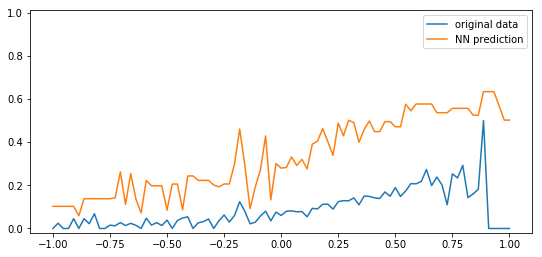

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

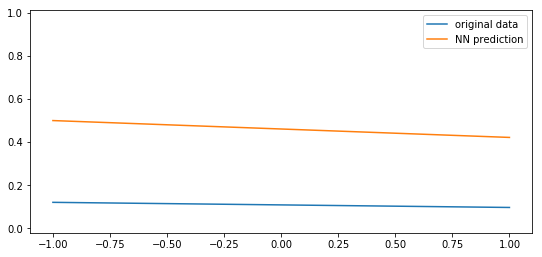

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

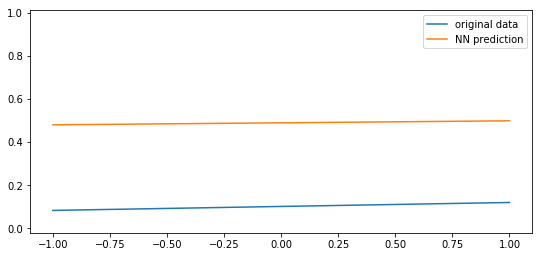

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

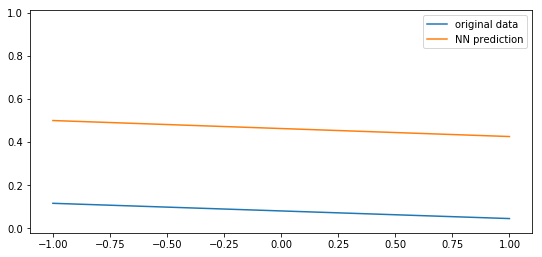

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

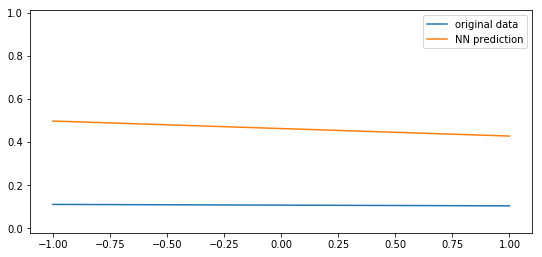

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

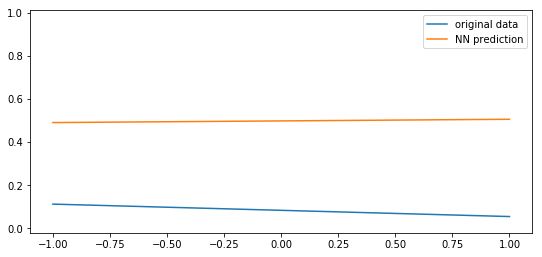

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

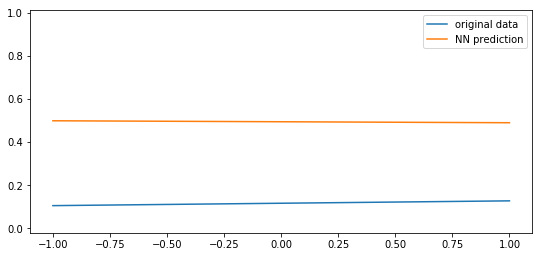

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

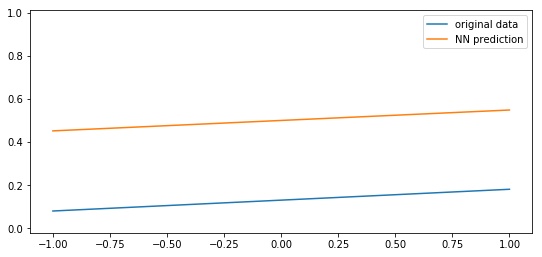

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

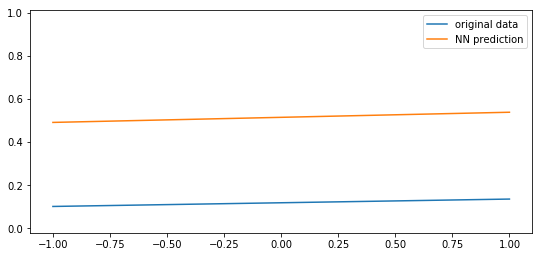

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

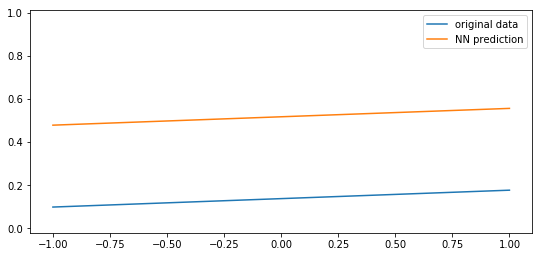

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

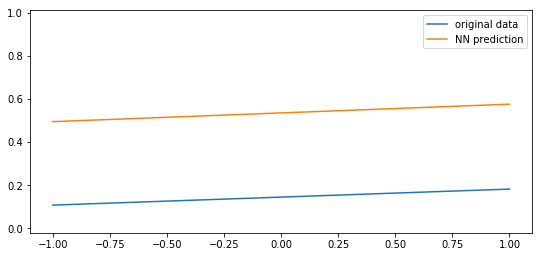

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

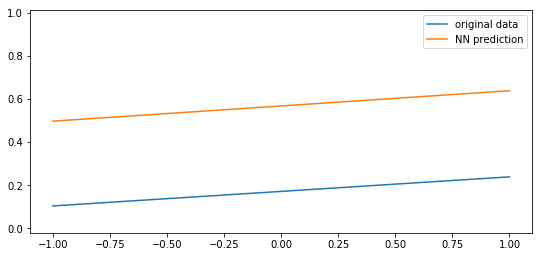

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

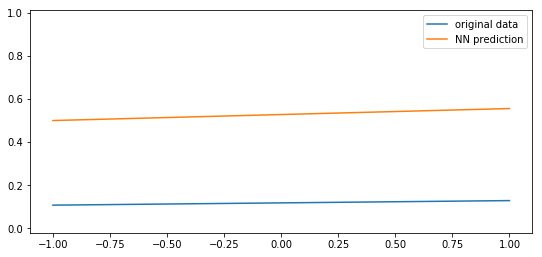

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

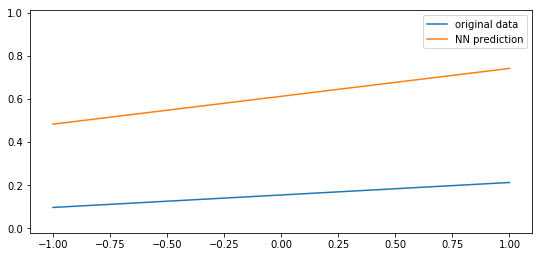

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

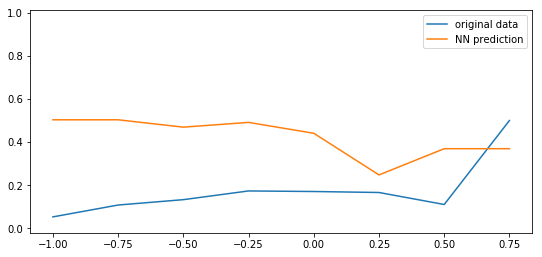

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

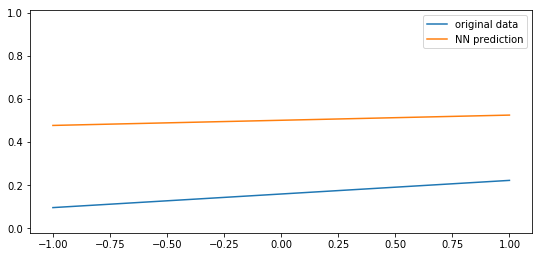

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

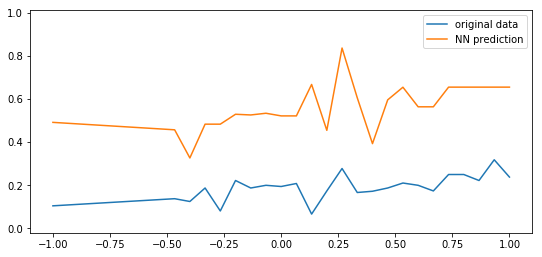

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

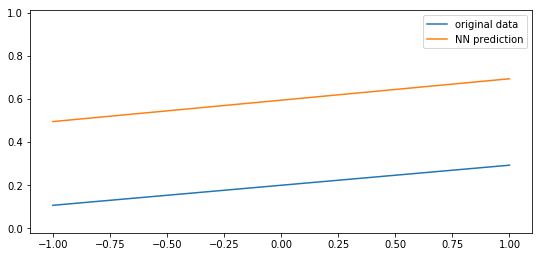

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

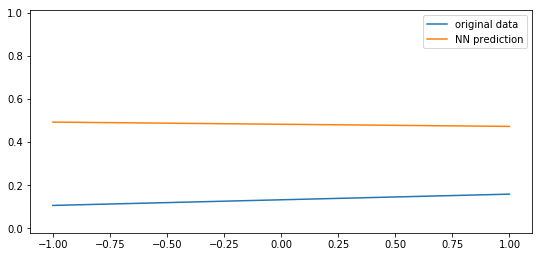

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

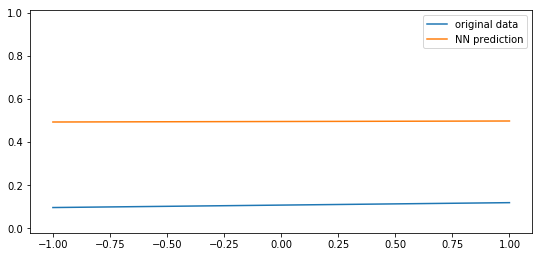

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

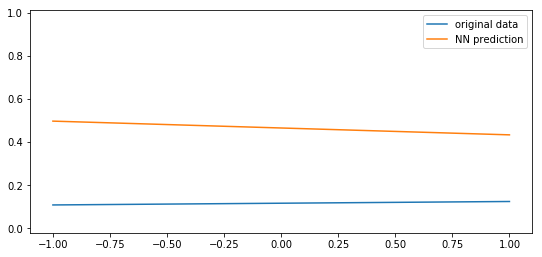

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

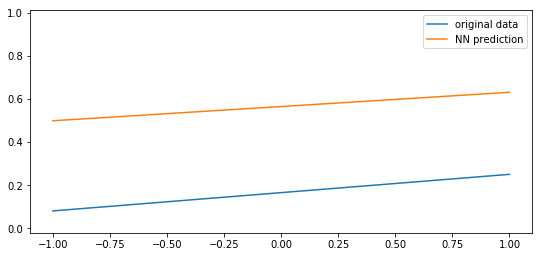

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

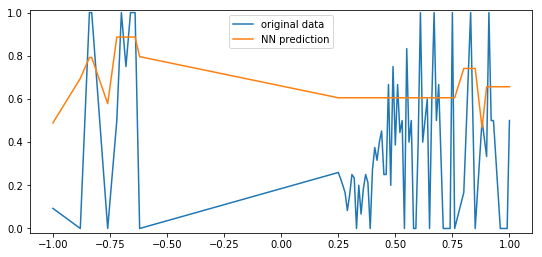

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

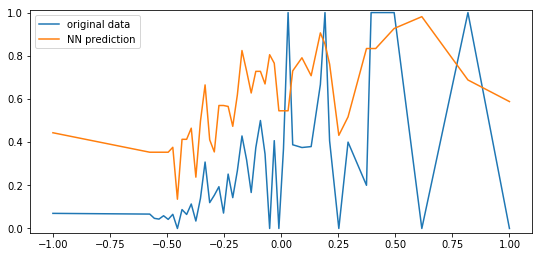

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

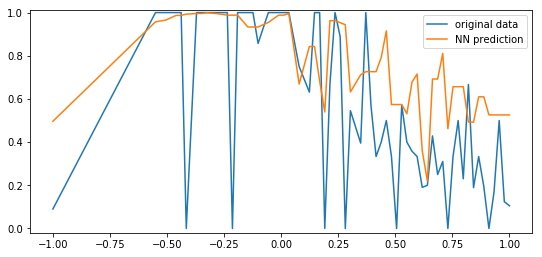

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

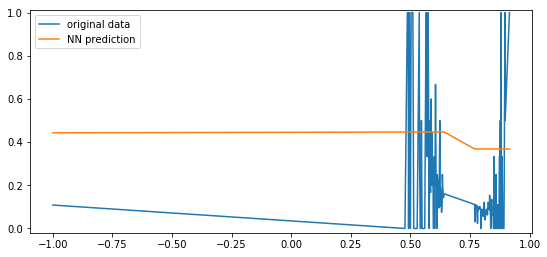

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

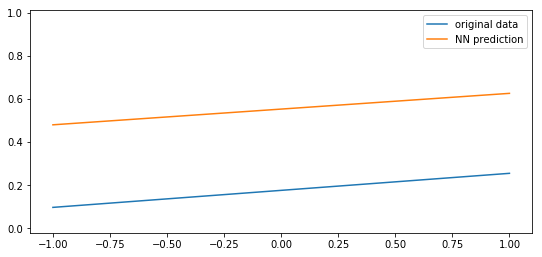

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

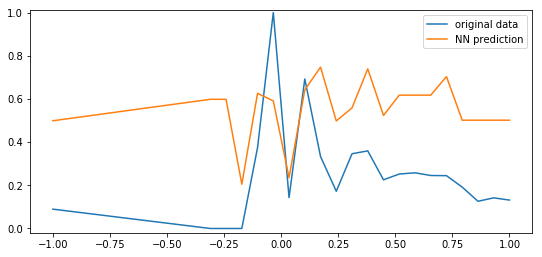

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

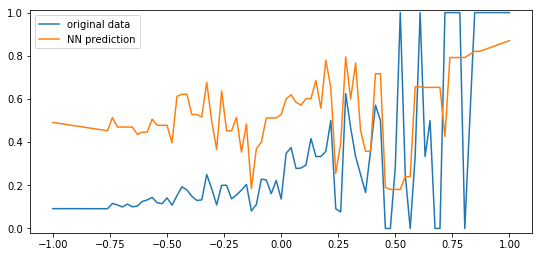

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

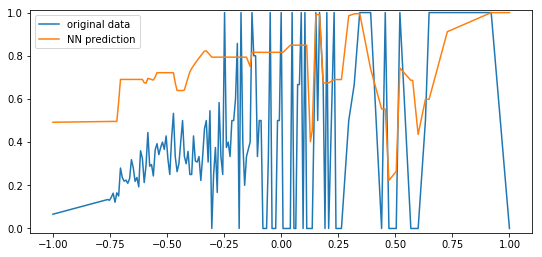

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

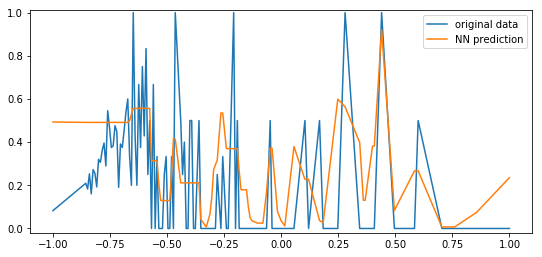

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

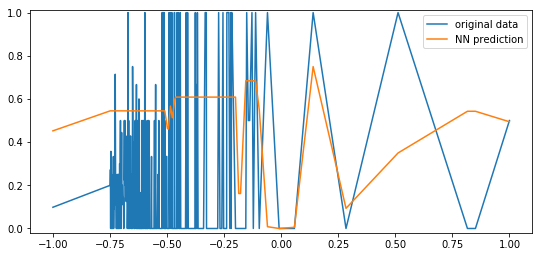

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

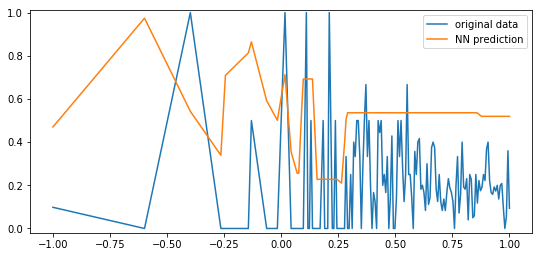

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

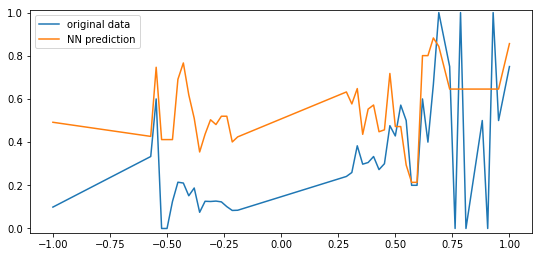

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

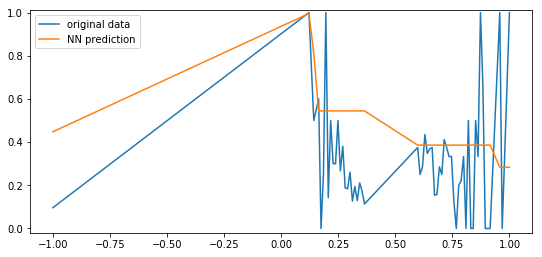

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

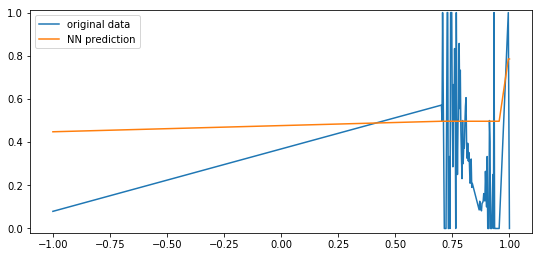

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

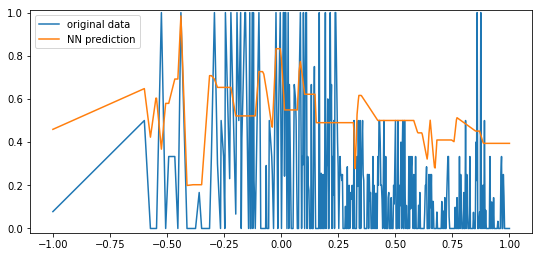

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

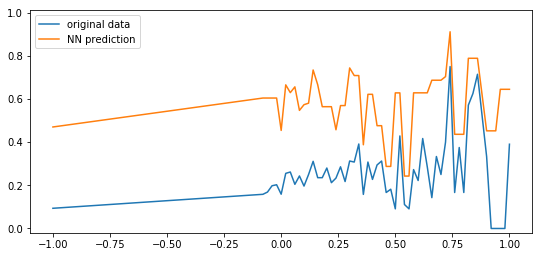

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

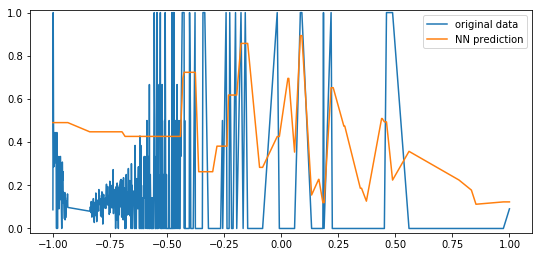

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

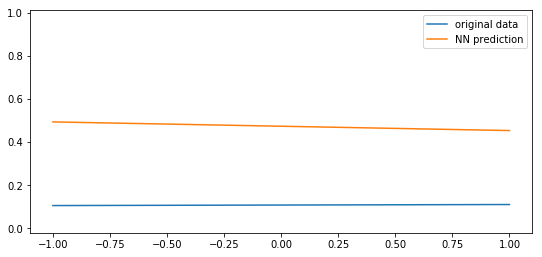

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

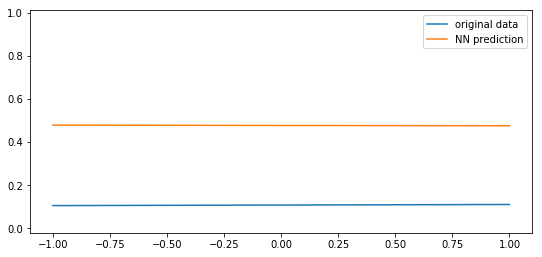

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

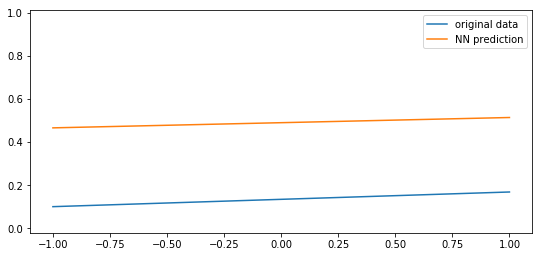

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

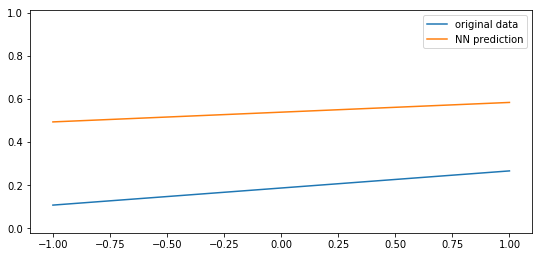

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

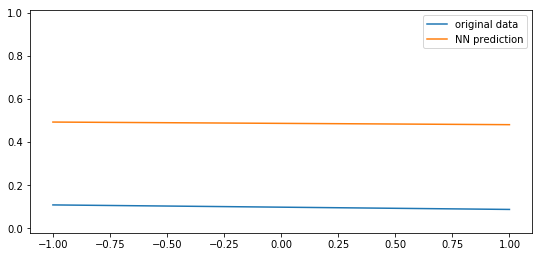

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

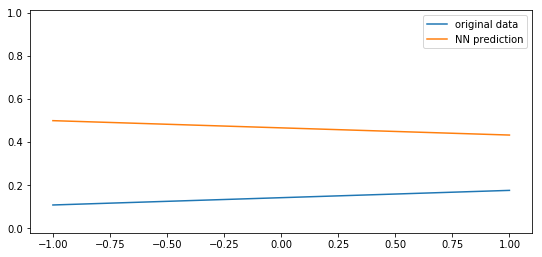

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

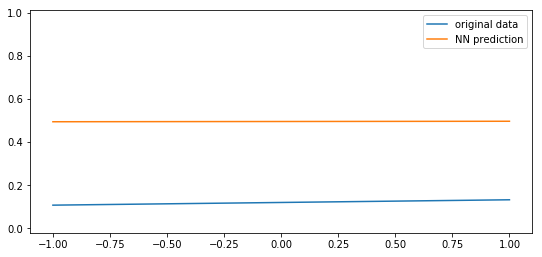

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [320]:
#@title After Second order Optimization
plot_all_hist()

In [321]:
accuracy(nn_model, x_test, y_test)

<tf.Tensor: id=156076425, shape=(), dtype=float32, numpy=0.89944136>